# Exercise Sheet 4: Neural Fields & Networks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import spatial
from scipy import signal

def logistic(h,a=1):
    return 1/(1+np.exp(-a*h))
def dlogistic(h,a=1):
    return a*(logistic(h,a)-np.power(logistic(h,a),2))

signtrafunc=lambda x: (np.sign(x)+1)/2

def gaussRBF(h,a=1):
    return np.exp(-(a*h)**2)

def dgaussRBF(h,a=1):
    return -2*a**2*h*np.exp(-(a*h)**2)

import os
os.chdir('C:/Users/Daniel Miklody/tubCloud/2020BCI-fNtD/exercises/data')

## Code given: Gradient Descent on a single neuron and an MLP
Rewrite the neuron class given and include the Gradient Descent training algorithm as a method. Use the sum of squares error to measure the output error.

Add a method calculating the last local error ($\delta$) of the neuron and one for training the neuron using the derivative of the ouput error $\frac{dE}{dy}=y-o$.
Keep the last input $x$, last output $y$, last activation $h$ and last delta $\delta$ values as object attributes, whenever they are recalculated.
The values of $h$,$x$,$y$ and $o$ are all to be taken as those of the current training data (= their last calculation).

The forumla you need is: $\delta = f'(h_i) \left(y-o\right)$. 

The train function updates the weights by the gradient descent weight update rule $w(t+1)=w(t)-\eta\delta(t)\cdot x(t)$ and the bias by $b(t+1)=b(t)-\eta\delta(t)$ with $\eta$ being the learning rate. As input arguments it should get the derivative of the output error $\frac{dE}{dy}=y-o$ and the learning rate.

To this extent, you need to make the link between the following neurons, connected by weights $w_k$ and their delta $\delta_k$, and the current neuron.

The forumla you need is: $\delta_i = f'(h_i) \sum_k w_k \delta_k$, where i is the index of the current neuron and k is the index of the following neurons (connected to it's output). For a single neuron as for the last layer neurons, the delta of the following neuron is replaced by the error graident of the output $\delta_k=\left(y-o\right)$ and the corresponding weight is $w_k=1$ as every output neuron in the model has only one unscaled output.

The train function updates the weights again by the gradient descent weight update rule $w(t+1)=w(t)-\eta\delta_i(t)\cdot x(t)$ and the bias by $b(t+1)=b(t)-\eta\delta_i(t)\cdot$.


Construct a class "MLP" with a list of layers of type "MLPlayer" called "MLP.layers" Also, there should be a method "MLP.out(x)" that returns the outputs of the whole network of the input vector "x".

Make sure, that the size of the weight vector is set to the number of inputs for the first layer and that the number of inputs for the following layers has to correspond with the number of neurons in the preceding layer. The number of outputs equals the number of neurons in the last layer.

* The init function takes the number of inputs *x* as an integer and the number of nodes for each layer as a list. The number of neurons per layer and the number of inputs should be passed to the initialization methods of an MLPlayer.

* Include the backpropagation training algorithm as a method "MLP.train()" into the class. The passed arguments should consist of the number of iterations (no stopping criteria in this case), the training input and the training output - both as function pointers - as well as the learning rate. It should iterate over the layers, which themselves iterate over their neurons. Deltas and W of the following layer will allways be the input to the previous.

* The function x_train has to produce a random array of inputs of size [NoInputs,] and o_train has to produce the corresponding target function output. They should work without an argument passed and the target training output $o$ should be calculated using only that vector $x$.

* The output of the method *train()* should consist of the sum-of-squares error within each iteration.

Do the same training on an XOR as in exercise sheet 2 task 5, using an architecture of 2 and then 3 neurons in the first layer and one output neuron in the second (you may use the sample solution code).

In [2]:
class neuron:    
    lasth=0
    lastout=0
    lastin=0
    
    def __init__(self,w,b,trafunc=logistic,dtrafunc=dlogistic):
        self.w=np.array(w)
        self.b=np.array(b)
        self.trafunc=trafunc
        self.dtrafunc=dtrafunc
        
    def out(self, x):
        self.lastin=x;
        self.lasth=np.dot(self.w,x)-self.b
        self.lastout=self.trafunc(self.lasth)
        return self.lastout   
    
    def delta(self,deltanext,weightsnext):
        df=self.dtrafunc(self.lasth)
        self.lastdelta=np.dot(deltanext,weightsnext)*df     
        return self.lastdelta
    
    def train(self,deltanext,weightsnext,learnrate=0.1):
        self.delta(deltanext,weightsnext)
        self.w=self.w-learnrate*self.lastdelta*self.lastin
        self.b=self.b+learnrate*self.lastdelta
        return self.lastdelta

class MLPlayer:
    def __init__(self,NodeNo,WeightNo,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=logistic,dtrafunc=dlogistic):
        self.nodes=[neuron(weightinit(WeightNo),biasinit(1),trafunc,dtrafunc) for i in range(NodeNo)]
    def out(self,x):
        return np.ravel([n.out(x) for n in self.nodes])
    def train(self,deltanext,W,learnrate=0.1):    
        Wo=np.array([n.w for n in self.nodes]).T
        deltas=np.array([ n.train(deltanext,W[ineur],learnrate) for ineur,n in enumerate(self.nodes)]).T
        return deltas, Wo

class MLP:
    def __init__(self,InputNo,NodeNos,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=logistic,dtrafunc=dlogistic):        
        self.NodeNos=np.append(InputNo,NodeNos)
        self.layers=[MLPlayer(self.NodeNos[i+1],self.NodeNos[i],weightinit,biasinit,trafunc,dtrafunc) for i in range(self.NodeNos.size-1)]
    def out(self,x):
        for i in range(len(self.layers)):
            x=self.layers[i].out(x)
        self.lastout=x
        return x
    def train(self,NumIt,x_train,o_train,learnrate=0.1):
        errors=np.zeros(NumIt)
        for i in range(NumIt):
            if callable(x_train):
                x=x_train()
            else:
                x=x_train[i]
            if callable(o_train):
                o=o_train(x)
            else:   
                o=o_train[i]                       
            y=self.out(x)
            if len(y)==1:
                o=np.array([o]) 
                y=np.array([y])
            deltas=y-o
            W=np.eye(y.shape[0])   
            for il, l in enumerate(reversed(self.layers)): 
                deltas, W=l.train(deltas,W,learnrate)
            errors[i]=0.5*np.sum(np.power(y-o,2))       
        return errors

## Task 1: logical functions (2 points - programming)
Train a single neuron on the logical functions below for a two-dimensional input $x$. Use instances of the neuron class above to build the equivalents to logical "or","and" and "xor"-functions and test them for 2-dimensional input vectors *x* resembling all possibilities of combinations ([0,0] [1,0], [0,1], [1,1]). Do 10.000 iterations and plot the evolution of the error (the error over the iteration number). You don't need to implement a stopping criterion.

Set the learning rate to $\eta=1$ and initialize the weight $w$ and the bias $b$ randomly with normal distribution (np.random.randn). Use the logistic function.

In the next cell you find an exemplary fuction training the neuron and plotting the evolution of the error. Use a random number generator for sample creation in every single iteration.

In [3]:
def train_and_display(NumIt,neuron1,inputfunc,targetfunc):
    errors=np.zeros(NumIt)
    for i in range(NumIt):
        x=inputfunc()
        neuron1.train(neuron1.out(x)-targetfunc(x),1,1)
        errors[i]=0.5*np.sum(np.power(neuron1.out(x)-targetfunc(x),2))
    plt.plot(errors)
    return neuron1

### a) AND function

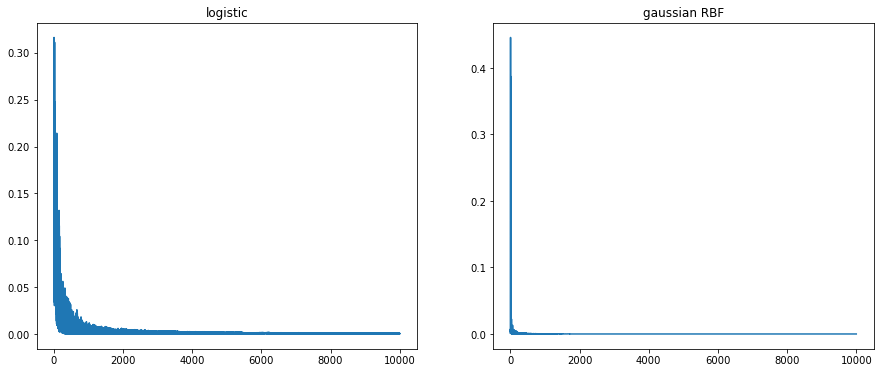

[0,0]-->[5.11984725e-05]					[0,0]-->[2.1580244e-09]
[1,0]-->[0.03319599]					[1,0]-->[0.00611971]
[0,1]-->[0.03416622]					[0,1]-->[0.00612173]
[1,1]-->[0.9595512]					[1,1]-->[0.99770827]
weights [6.50818299 6.53799544],bias [9.87974966]       weights [2.20951272 2.20958598],bias [4.46699817]


In [4]:
andi=neuron(np.random.randn(2),np.random.randn(1))
NumIt=10000

plt.figure(figsize=[15,6])

plt.subplot(121)
andi=train_and_display(NumIt,andi,lambda:np.random.randint(2,size=2),lambda x:x[0]&x[1])
plt.title('logistic')

#Find here the same for a Gaussian RBF:
andiG=neuron(np.random.randn(2),np.random.randn(1),gaussRBF,dgaussRBF)
plt.subplot(122)
andiG=train_and_display(NumIt,andiG,lambda:np.random.randint(2,size=2),lambda x:x[0]&x[1])
plt.title('gaussian RBF')
plt.show()

print('[0,0]-->'+str(andi.out([0,0]))+'\t\t\t\t\t[0,0]-->'+str(andiG.out([0,0])))
print('[1,0]-->'+str(andi.out([1,0]))+'\t\t\t\t\t[1,0]-->'+str(andiG.out([1,0])))
print('[0,1]-->'+str(andi.out([0,1]))+'\t\t\t\t\t[0,1]-->'+str(andiG.out([0,1])))
print('[1,1]-->'+str(andi.out([1,1]))+'\t\t\t\t\t[1,1]-->'+str(andiG.out([1,1])))   
print('weights '+str(andi.w)+',bias '+str(andi.b)+'       weights '+str(andiG.w)+',bias '+str(andiG.b))

### b) OR function

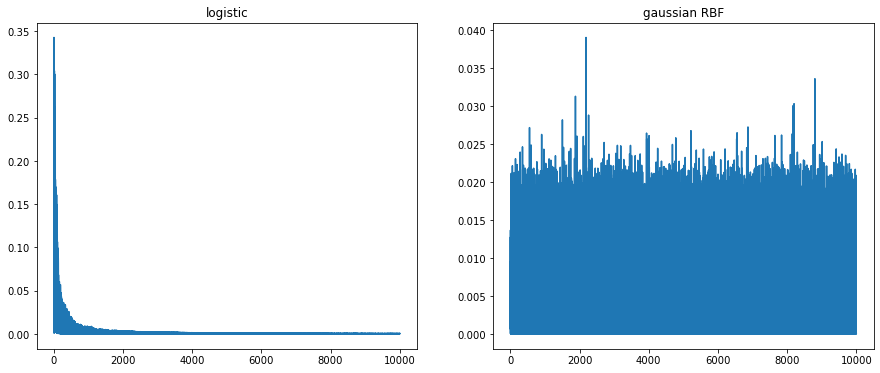

[0,0]-->[0.03358885]					[0,0]-->[0.35958733]
[1,0]-->[0.97949705]					[1,0]-->[0.99066981]
[0,1]-->[0.97870298]					[0,1]-->[0.99999592]
[1,1]-->[0.99998417]					[1,1]-->[0.43169387]
weights [7.22586562 7.18705622],bias [3.35939534]       weights [-0.9145155  -1.01335555],bias [-1.01133487]


In [5]:
ori=neuron(np.random.randn(2),np.random.randn(1))
NumIt=10000

plt.figure(figsize=[15,6])

plt.subplot(121)
ori=train_and_display(NumIt,ori,lambda:np.random.randint(2,size=2),lambda x:x[0]|x[1])
plt.title('logistic')

#Find here the same for a Gaussian RBF:
oriG=neuron(np.random.randn(2),np.random.randn(1),gaussRBF,dgaussRBF)
plt.subplot(122)
oriG=train_and_display(NumIt,oriG,lambda:np.random.randint(2,size=2),lambda x:x[0]|x[1])
plt.title('gaussian RBF')
plt.show()

print('[0,0]-->'+str(ori.out([0,0]))+'\t\t\t\t\t[0,0]-->'+str(oriG.out([0,0])))
print('[1,0]-->'+str(ori.out([1,0]))+'\t\t\t\t\t[1,0]-->'+str(oriG.out([1,0])))
print('[0,1]-->'+str(ori.out([0,1]))+'\t\t\t\t\t[0,1]-->'+str(oriG.out([0,1])))
print('[1,1]-->'+str(ori.out([1,1]))+'\t\t\t\t\t[1,1]-->'+str(oriG.out([1,1])))   
print('weights '+str(ori.w)+',bias '+str(ori.b)+'       weights '+str(oriG.w)+',bias '+str(oriG.b))

### c) XOR function

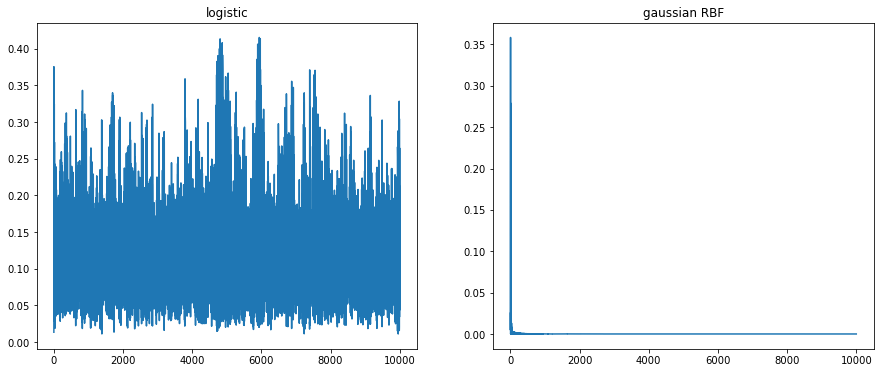

[0,0]-->[0.5200063]					[0,0]-->[0.00424728]
[1,0]-->[0.61094185]					[1,0]-->[0.99965334]
[0,1]-->[0.29766848]					[0,1]-->[0.99964385]
[1,1]-->[0.38054864]					[1,1]-->[0.00355953]
weights [ 0.37120499 -0.93849313],bias [-0.08006797]       weights [-2.35560056 -2.35585388],bias [-2.33698026]


In [6]:
xori=neuron(np.random.randn(2),np.random.randn(1))
NumIt=10000

plt.figure(figsize=[15,6])

plt.subplot(121)
xori=train_and_display(NumIt,xori,lambda:np.random.randint(2,size=2),lambda x:x[0]^x[1])
plt.title('logistic')

#Find here the same for a Gaussian RBF:
xoriG=neuron(np.random.randn(2),np.random.randn(1),gaussRBF,dgaussRBF)
plt.subplot(122)
xoriG=train_and_display(NumIt,xoriG,lambda:np.random.randint(2,size=2),lambda x:x[0]^x[1])
plt.title('gaussian RBF')
plt.show()

print('[0,0]-->'+str(xori.out([0,0]))+'\t\t\t\t\t[0,0]-->'+str(xoriG.out([0,0])))
print('[1,0]-->'+str(xori.out([1,0]))+'\t\t\t\t\t[1,0]-->'+str(xoriG.out([1,0])))
print('[0,1]-->'+str(xori.out([0,1]))+'\t\t\t\t\t[0,1]-->'+str(xoriG.out([0,1])))
print('[1,1]-->'+str(xori.out([1,1]))+'\t\t\t\t\t[1,1]-->'+str(xoriG.out([1,1])))   
print('weights '+str(xori.w)+',bias '+str(xori.b)+'       weights '+str(xoriG.w)+',bias '+str(xoriG.b))

## Task 2 Train an MLP on the XOR (2 points - programming)
Train a Multi-Layer-Perceptron on the logical "xor"-function.Do 10.000 iterations and plot the evolution of the error. You don't need to implement a stopping criterion. Use the logistic function.

Set the learning rate to $\eta=1$.

Investigate the following steps:

a) The network should consist of two layers, where the first has the two input neurons and the second only one output neuron. Does it always converge?

b) The network should consist of two layers, where the first has the three  input neurons and the second only one output neuron. Does it now always converge?

What can we learn from this?

The MLP is already implemented in the helper functions Exercise2helperPy37 or Exercise2helperPy27 (depending on your python version 3.6 or 2.7). In the next task sheet, we will actually implement it ourselves, so if you have free time, you can of course already do that now!
The syntax of the contained MLP class is:
*NeuralNetwork=MLP(NoInputs,ListNoNeuronsPerLayer)*
for initialization and 
*errors=NeuralNetwork.train(NoIterations,x, o ,learnrate)* for training. $x$ and $o$ can either be function pointers as defined or arrays of samples. If they are functions, $x$ has to produce a random array of inputs of size [NoInputs,] and $o(x)$ has to produce the corresponding target function output. If they are samples they have to have the shape *x.shape=[NoIterations,NoInputs]* and *o.shape=[NoIterations,NoOutputs]*.



[0,0]-->[0.02360616]
[1,0]-->[0.96995838]
[0,1]-->[0.43650844]
[1,1]-->[0.43931596]


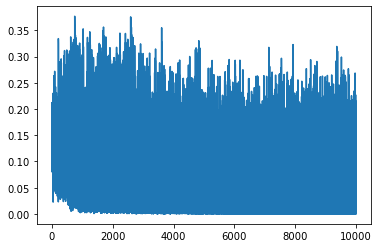

[0,0]-->[0.02261924]
[1,0]-->[0.97205332]
[0,1]-->[0.97979336]
[1,1]-->[0.02063853]


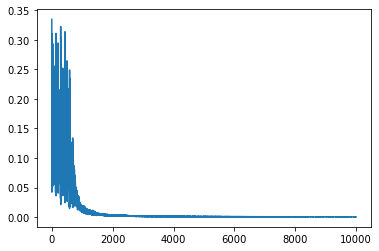

In [7]:
LayerNeuronNos=[2,1]
NeuralNetwork1=MLP(2,LayerNeuronNos)
learnrate=1
NumIt=10000

errors=NeuralNetwork1.train(NumIt,lambda:np.random.randint(2,size=2), lambda x:x[0]^x[1] ,learnrate)

print('[0,0]-->'+str(NeuralNetwork1.out([0,0])))
print('[1,0]-->'+str(NeuralNetwork1.out([1,0])))
print('[0,1]-->'+str(NeuralNetwork1.out([0,1])))
print('[1,1]-->'+str(NeuralNetwork1.out([1,1])))
plt.plot(errors)
plt.show()


LayerNeuronNos=[3,1]
NeuralNetwork2=MLP(2,LayerNeuronNos)

errors=NeuralNetwork2.train(NumIt,lambda:np.random.randint(2,size=2), lambda x:x[0]^x[1] ,learnrate)

print('[0,0]-->'+str(NeuralNetwork2.out([0,0])))
print('[1,0]-->'+str(NeuralNetwork2.out([1,0])))
print('[0,1]-->'+str(NeuralNetwork2.out([0,1])))
print('[1,1]-->'+str(NeuralNetwork2.out([1,1])))
plt.plot(errors)
plt.show()


## Task 3: A neural network described by a connectivity matrix (5 points - programming)
We will now translate the network described by objects into a connectivity matrix and then iterate over points in time in order to propagate the input to the output.

The connectivity is only supposed to be close to instantaneous in this task, we will introduce delay between different areas in the next task. The connectivity is hence a matrix $W$ of size (NoNeurons, NoNeurons).

The vector of network state variables $\mathbf{x}_t$  at time point $t$ shall include the input in the first variables. The new state $\mathbf{x}_{t+1}$ for the next time step is calculated by:
$\mathbf{x}_{t+1}=f(\mathbf{h})=f(\mathbf{W} \cdot \mathbf{x}_{t} -\mathbf{b})$

**Tasks:**

a) Calculate the connectivity matrix $W$ and the bias vector $\mathbf{b}$ out of the MLP from task 2 b) (if you have not succeeded with training the MLP simply use a feedforward MLP of size (3,1) with arbitrary wiring). To this extent, translate layerwise indexed neurons into a unique index across layers and then connect neurons from each layer only with the preceeding layer/the input, respectively. Print the matrix to command line.

b) Simulate a propagation of a random logic vector of size 2 (as in task 2) until it reaches the output layer. This means iteration over time points, where in each time point the output $f(\mathbf{h})$ from the preceeding time point $t$  is used as the input for the next time point $t+1$. Print the state variables $x_t$ at every step and the output of the network at the end to the command line.

In [8]:
TotalNodeNo=np.sum(NeuralNetwork2.NodeNos)
NoLayers=len(NeuralNetwork2.NodeNos)
W=np.zeros((TotalNodeNo,TotalNodeNo))
b=np.zeros(TotalNodeNo)
idx=0
idxLayerbefore=0
for iLayer in range(NoLayers-1):
    Nneurons1=NeuralNetwork2.NodeNos[iLayer]
    Nneurons2=NeuralNetwork2.NodeNos[iLayer+1]
    idxLayerstart=Nneurons1+idxLayerbefore
    for iNeuron2 in range(Nneurons2):        
        w=NeuralNetwork2.layers[iLayer].nodes[iNeuron2].w       
        for iNeuron1 in range(Nneurons1):
            W[idxLayerstart+iNeuron2,iNeuron1+idxLayerbefore]=NeuralNetwork2.layers[iLayer].nodes[iNeuron2].w[iNeuron1]        
        b[idxLayerstart+iNeuron2]=NeuralNetwork2.layers[iLayer].nodes[iNeuron2].b
        idx+=1
    idxLayerbefore=idx-1   

print('W=\n'+str(W)+'\n')
print('b='+str(b))

W=
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [-5.20083283  4.94739892  0.          0.          0.          0.        ]
 [-5.83408929  5.99952316  0.          0.          0.          0.        ]
 [-2.61046305  2.79467478  0.          0.          0.          0.        ]
 [ 0.          0.          7.43526347 -9.00376048  3.40005406  0.        ]]

b=[ 0.          0.          2.81946521 -2.86429773  2.0777181  -3.95513025]


In [9]:
x_in=np.random.randint(2,size=2)
x=np.zeros(TotalNodeNo)
x[0:2]=x_in
print('x_in=' +str(x_in)+'\n')
for t in range(NoLayers-1):
    print('x('+str(t)+')='+str(x)+'\n')
    x=logistic(W.dot(x)-b)
print('x('+str(t+1)+')='+str(x)+'\n')    
print('y='+str(x[-1]))

x_in=[0 1]

x(0)=[0. 1. 0. 0. 0. 0.]

x(1)=[0.5        0.5        0.89358869 0.99985861 0.67193651 0.98120389]

x(2)=[0.5        0.5        0.04991726 0.9501222  0.12072184 0.97979336]

y=0.9797933637889623


## Task 4 : Neural Mass Model (6 points - programming)

We will now look at a neural mass model based on the source positions from our head model (gridpos.npy).
You will find the connected equations again on the last slides of the current lecture.


** Tasks: **

a) Derive the distance matrix $\mathbf{D}$ from the source positions in gridpos using scipy.spatial.distance_matrix(...).

b) Calculate the matrix of weights $\mathbf{W}_0$ with dimensionality (NoSources,NoSources) by distance without delay using the equation $\mathbf{W}=a_0 e^{-b_0\mathbf{D}}+a_1 e^{-b_1\mathbf{D}}$. Use $a_0=0.03$, $b_0=10$ for replicating excitatory connections and $a_1=-0.25$ and $b_1=50$ for inhibitory. Plot the matrix $\mathbf{W}_0$ using imshow.

c) Calculate the delay $\Delta t=\frac{\mathbf{D}}{c}+\Delta t_0$ for each connection by using the transmission speed $c=0.5 \frac{m}{s}$ and the synaptic delay $\Delta t_0=2ms$ as a matrix corresponding to the dimensions of $\mathbf{D}$. Then introduce a sampling rate of $fs=100Hz$ and discretize the delay into time samples. Calculate the maximal time delay $T$.

d) Combine the results of b) and c) into an array of size (NoSources,NoSources,MaxDelay) by expanding $W_0$ into the time domain/delay. We will call this array $W$.

e) Simulate the multi-variate time course for a random starting point of the network over $1s$ with $fs=100Hz$ by creating a random array X of size (NoSources,MaxDelay) with uniform distribution (np.random.rand) and then propagate activity over time. To this extent, use the current state history array $\mathbf{X}$ of the network to calculate the source activity vector for the next time step by $\mathbf{y}=f(\mathbf{W} \odot \mathbf{X})$. $\odot$ can be calculated using np.tensordot(W,X,axes=2). Then $\mathbf{X}$ can be shifted like a circular buffer so that the oldest source activity vector is discarded while the newest is set to $\mathbf{y}$.

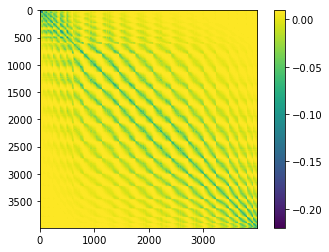

In [18]:
gridpos=np.load('gridpos.npy')
fs=100
c=0.5
wde=10
wdi=50
T0=2/1000*fs
Nsource=gridpos.shape[0]

D=spatial.distance_matrix(gridpos,gridpos)

W_tmp=0.03*np.exp(-wde*D)-0.25*np.exp(-wdi*D)
plt.imshow(W_tmp)
plt.colorbar()


In [19]:
Ts=np.rint(D/c*fs+T0).astype(int)
Tmax=Ts.max().astype(int)+1

W=np.zeros((Nsource,Nsource,Tmax))

for i in range(Nsource):
    for j in range(Nsource):
        W[i,j,Ts[i,j]]=W_tmp[i,j]

In [20]:
SimTime=100
X=np.random.rand(Nsource,SimTime)
for t in range(SimTime):
    #x=np.tensordot(W,X[:,:Tmax],axes=2)
    x=logistic(np.tensordot(W,X[:,:Tmax],axes=2))
    X=np.roll(X,1,1)
    X[:,0]=x

3668


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


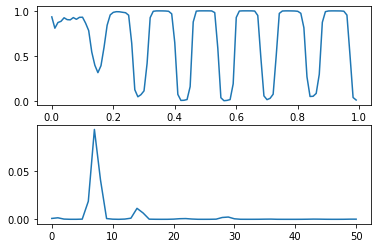

In [21]:
sourid=np.random.randint(Nsource)
print(sourid)
plt.subplot(211)
plt.plot(np.arange(SimTime)/fs,np.flip(X[sourid,:]))
[f,pxx]=signal.welch(X[sourid,:],fs)
plt.subplot(212)
plt.plot(f[f<=100],pxx[f<=100])